## Simple Anomaly Detection using Live Data

### Setup

#### Install the Cognite Python SDK

In [0]:
!pip install cognite-sdk

    100% |████████████████████████████████| 61kB 2.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/46/a1/38/a6b413db5facbffdc9c50ed90186ecd0ce6029bb9dd46391a9
Successfully built cognite-logger


#### Import further required packages

In [0]:
import os
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bokeh.io import output_notebook, push_notebook, show
from bokeh.layouts import column
from bokeh.models import Band, LinearAxis, Range1d
from bokeh.models.sources import ColumnDataSource
from bokeh.palettes import Category10
from bokeh.plotting import figure

from cognite.client import CogniteClient

#### Connect to the Cognite Data Platform

* This client object is how all queries will be sent to the Cognite API to retrieve data.
* When prompted for your API key, use the key provided.

In [0]:
client = CogniteClient(api_key="ODg4MWMwZjktNDlmOS00ZTcxLTg3ODgtMDZjMjhhMzNjYTEx")

**Accessing Cognite Data Platform (CDP)**

The CDP organizes digital information about the physical world.
There are different kinds of resources stored on the CDP. Here, we care about assets, time series and datapoints.

 * [Assets](https://doc.cognitedata.com/api/0.5/#tag/Assets) are digital representations of physical objects or groups of objects, and assets are organized into an asset hierarchy. For example, an asset can represent a water pump which is part of a subsystem on an oil platform.


 * A [Time Series](https://doc.cognitedata.com/api/0.5/#tag/Time-series) consists of a sequence of data points connected to a single asset. For example: A water pump asset can have a temperature time series that records a data point in units of °C every second.


 * It is important to refer back to the [SDK](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/cognite.html) for specific details on arguments on all avaiable methods on how to access these objects.

In this example, we are working with a model windmill and want to perform simple anomaly detection using *RPM*, *torque* and *wind speeds* sensor readings. In terms of CDP resources, we need to obtain the *datapoints* corresponding to those three *time series*.


A **Datapoint** in the CDP is stored as a key value pair:

 * timestamp is the time since epoch in milliseconds

 * value is the reading from the sensor

**Checking if we are receiving sensor readings: pulling RPM data**

In [4]:
a = client.datapoints.get_latest('rpm').to_pandas()
a.timestamp = pd.to_datetime(a.timestamp, unit='ms')
a

,timestamp,value
0,2019-04-08 15:31:54.344,67.84


### Generating training data

#### Live Plotter class

The class below downloads datapoints for the specified time series nearly continuously using the method `client.datapoints.get_latest` (returning a Python generator) and creates a plot in *Bokeh*

In [0]:
class LivePlotter:
    def __init__(self, tags, update_frequency=0.1, n_show=10, training_data_threshold=60):
        self.tags = tags
        self.update_frequency = update_frequency
        self.n_show = n_show
        self.training_data_threshold = training_data_threshold
        output_notebook()

    def plot(self):
        if self.tags[0][-1] in [2, 3]:
            plot_labels = [tag[:-1] for tag in self.tags]
        else:
            plot_labels = self.tags.copy()

        plot_colors = Category10[3]
        P = [client.datapoints.get_latest(name=tag).to_pandas() for tag in self.tags]
        self.start_time = np.min([pp["timestamp"].values[0] for pp in P])
        x = [pd.to_datetime(self.start_time, unit="ms")]
        y = [pp["value"].values for pp in P]

        my_figure = figure(
            title="Windmill Sensor Values",
            tools="",
            plot_width=900,
            plot_height=500,
            x_axis_type="datetime",
            y_range=[-50, 200],
        )
        test_data = ColumnDataSource(
            dict(x=[x.copy()] * len(self.tags), y=y.copy(), colors=plot_colors.copy(), labels=plot_labels.copy())
        )
        line = my_figure.multi_line(
            xs="x", ys="y", line_color="colors", legend="labels", source=test_data, line_width=5
        )

        my_figure.legend.location = "center_left"

        new_data = dict(x=[x] * len(self.tags), y=y, colors=plot_colors, labels=plot_labels)

        handle = show(my_figure, notebook_handle=True)

        start_data_gen = dt.datetime.now()
        printed_enough_data = False

        try:

            for P in zip(*[client.datapoints.live_data_generator(name=tag, update_frequency=self.update_frequency) for tag in self.tags]):

                x.append(np.max([pd.to_datetime(pp["timestamp"], unit="ms") for pp in P]))  # naive synchronization
                y = [np.append(yyy, ppp["value"]) for yyy, ppp in zip(y, P)]

                nump = np.minimum(self.n_show, len(x))
                x = x[-nump:]  # prevent filling ram
                new_data["x"] = [x] * len(self.tags)
                new_data["y"] = y = [yyy[-nump:] for yyy in y]  # prevent filling ram

                test_data.stream(new_data, nump)
                self.end_time = int(x[-1].timestamp() * 1000)
                push_notebook(handle=handle)
                if (dt.datetime.now() - start_data_gen).total_seconds() > self.training_data_threshold and not printed_enough_data:
                    print("Sufficient training data size.")
                    printed_enough_data = True

        except KeyboardInterrupt:

            print('Interrupted')

#### Plot live data
The windmill is uploading sensor data to CDP, while the `LivePlotter.plot` method is downloading the resulting datapoints as described above.

In [7]:
# choose windmill 
windmill_no = 1

# no of most recent secs to plot
n_show = 60

# length of training sample
training_data_threshold = 60 # in secs: 60 as default

if windmill_no in [2,3, 5]:
    tags = [tag + str(int(windmill_no)) for tag in ["rpm", "torque", "wind"]]  
else:
    tags = ["rpm", "torque", "wind"]
    
plotter = LivePlotter(tags, update_frequency=0.1, n_show=n_show, training_data_threshold=training_data_threshold)
plotter.plot()

Loading BokehJS ...

Interrupted


#### Retrieve timestamps at start and end of the above plotting exercise

Below, we will download datapoints for the RPM, torque and wind speed time series in the form of a (synchronized) Pandas dataframe. However, we will have to specify a *start* and *end* time for the datapoints we want to fetch. There are two alternative ways:
 * use start and end timestamps from your own run of `LivePlotter.plot`
 * use mine (you will obtain exactly the same training data)

**Using your run of the live plotter**

In [0]:
#start = plotter.start_time
#end   = plotter.end_time

**Type in values provided by me manually**

In [0]:
start = 1554740843080
end = 1554740908355


### Train a model

#### Download a Pandas DataFrame of synchronized datapoints for RPM, torque and windspeed

In [40]:
data_train = client.datapoints.get_datapoints_frame(
            time_series=tags,
            start=int(start),
            end=int(end),
            aggregates=['avg'],
            granularity='1s'
        )
data_train

,timestamp,rpm|average,torque|average,wind|average
0,1554740843000,67.848121,9.030879,25.0
1,1554740844000,68.926445,8.953996,25.0
2,1554740845000,69.010313,8.984037,25.0
3,1554740846000,68.185706,9.074067,25.0
4,1554740847000,68.408536,8.978612,25.0
5,1554740848000,68.029200,9.015914,25.0
6,1554740849000,68.224365,9.051205,25.0
7,1554740850000,67.270965,9.023763,25.0
8,1554740851000,68.022106,9.022518,25.0
9,1554740852000,68.412894,9.119010,25.0


In [41]:
data_train.describe()

,timestamp,rpm|average,torque|average,wind|average
count,7.100000e+01,71.000000,71.000000,71.0
mean,1.554741e+12,68.498793,9.060446,25.0
std,2.063977e+04,0.482807,0.063559,0.0
min,1.554741e+12,67.270965,8.953996,25.0
25%,1.554741e+12,68.025653,9.012228,25.0
50%,1.554741e+12,68.567172,9.051205,25.0
75%,1.554741e+12,68.756379,9.100667,25.0
max,1.554741e+12,69.350000,9.286909,25.0


#### Build a simple anomaly detector

To keep things as simple as possible, we recommend the following trivial version of the *functional leave-one-out approach*:
 * use a simple [Scikit-learn linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
 * for each sensor (RPM, torque and wind speed):
   * train a linear model for the given sensor using the other two (e.g. train a model for RPM using torque and wind speed as predictors)
   * compute the residuals (*actual vs. predicted on the training data*) as well as the mean and standard deviation of the latter (you could *split your training data in half*: the first half is used to train the linear regression model, the second half to compute the residuals and their mean and standard deviation)
 * write a function `predict_AD` that takes a DataFrame `data_test` with the same columns as `data_train` as an argument and does the following for each sensor:
   * computes the residuals/prediction errors using the above models
   * standardizes the residuals using the means and standard deviations computed above:
   $$resid_{std} = (resid - mean(resid))/(std(resid))$$
   * creates a binary anomaly indicator, which takes the value **1 for a given datapoint** if for **any** sensor the standardized residual is greater than one:
   $$resid_{std} > 1.0$$
   * returns an array containing the anomaly indicator
 * instead of linear regression you can try a [Scikit-learn Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
 
 
 

74.16196804083792

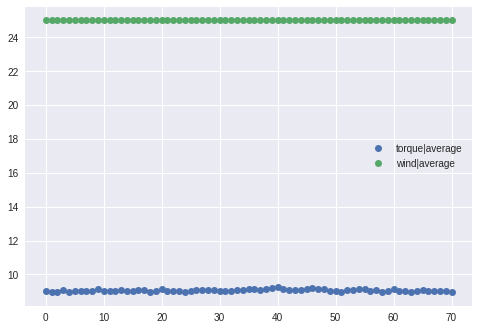

In [63]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

nrows = data_train.count

# RPM data
RPM_data = data_train.drop(["timestamp", "rpm|average"], axis = 1)
RPM_data.plot(style="o")

reg_RPM = LinearRegression().fit(X = RPM_data, y = data_train["rpm|average"])
reg_RPM.score(X = RPM_data, y = data_train["rpm|average"])
reg_RPM.coef_
reg_RPM.intercept_

#predict(X = RPM_data)



9.80244753120765

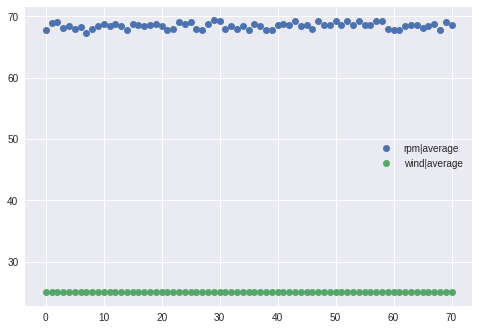

In [65]:
# TORQUE data
Torque_data = data_train.drop(["timestamp", "torque|average"], axis = 1)
Torque_data.plot(style="o")

reg_torque = LinearRegression().fit(X = Torque_data, y = data_train["torque|average"])
reg_torque.score(X = Torque_data, y = data_train["torque|average"])
reg_torque.coef_
reg_torque.intercept_



25.0

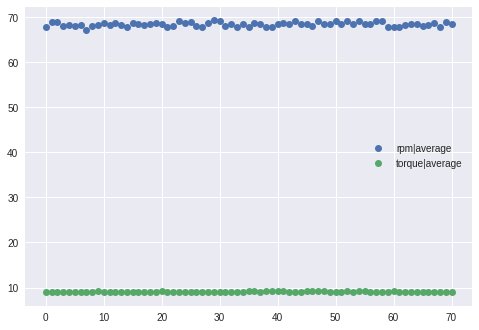

In [57]:
# WIND data
Wind_data = data_train.drop(["timestamp", "wind|average"], axis = 1)
Wind_data.plot(style="o")

reg_wind = LinearRegression().fit(X = Wind_data, y = data_train["wind|average"])
reg_wind.score(X = Wind_data, y = data_train["wind|average"])
reg_wind.coef_
reg_wind.intercept_

In [0]:
# Funksjon Predict

### Run the anomaly detector on test data

#### Plot some more live data for testing (with anomalies this time)

In [64]:
plotter_test = LivePlotter(tags, update_frequency=0.1, n_show=n_show, training_data_threshold=training_data_threshold)
plotter_test.plot()

Loading BokehJS ...

Interrupted


#### Set start and end time for downloading test data

In [0]:
start_test = 1554741968798
end_test = 1554742065097

#### Download a Pandas DataFrame of synchronized datapoints for testing

In [0]:
data_test = client.datapoints.get_datapoints_frame(
            time_series=tags,
            start=int(start_test),
            end=int(end_test),
            aggregates=['avg'],
            granularity='1s'
        )

#### Compute anomaly indicator using the function `predict_AD` from above

In [67]:
data_test

,timestamp,rpm|average,torque|average,wind|average
0,1554741968000,68.448514,9.220484,25.0
1,1554741969000,68.672580,9.208142,25.0
2,1554741970000,68.594245,9.278549,25.0
3,1554741971000,67.840000,9.197692,25.0
4,1554741972000,68.519811,9.162844,25.0
5,1554741973000,67.994494,9.189444,25.0
6,1554741974000,68.524755,9.257100,25.0
7,1554741975000,67.840000,9.224982,25.0
8,1554741976000,67.911593,9.280154,25.0
9,1554741977000,69.270102,9.201417,25.0


In [69]:
RPM_test = data_test.drop(["timestamp", "rpm|average"], axis = 1)
RPM_predict = reg_RPM.predict(RPM_test)
RPM_predict


array([68.39876252, 68.40647648, 68.36246916, 68.41300863, 68.43478962,
       68.41816352, 68.37587596, 68.39595099, 68.36146623, 68.4106798 ,
       68.43837069, 68.44273087, 68.39250931, 68.33884625, 68.35723605,
       68.39541806, 68.42322579, 68.41140619, 68.40604769, 68.34769565,
       68.32124633, 68.37792435, 68.39620734, 68.41451496, 68.43254384,
       68.39332628, 68.37222338, 68.33367259, 68.37268131, 68.38476228,
       68.38863063, 64.13250828, 59.29068307, 59.28022849, 59.19800952,
       59.32003642, 63.3608619 , 68.37437263, 68.36508167, 68.34868969,
       68.34874015, 68.38410765, 68.39973924, 68.37106323, 68.41431883,
       68.46499983, 68.38611769, 68.38353368, 68.4061028 , 68.39430059,
       68.39836762, 68.42751514, 68.4333549 , 68.40512781, 60.7490858 ,
       59.18942769, 59.08007845, 59.26801507, 68.16603454, 68.32859095,
       68.34612213, 68.40825296, 68.37820795, 68.36640715, 68.39028685,
       68.43069995, 68.37171101, 68.32871249, 68.35418712, 68.39

In [0]:
RPM_test = data_test.drop(["timestamp", "rpm|average"], axis = 1)
RPM_predict = reg_RPM.predict(RPM_test)
RPM_predict